<a href="https://colab.research.google.com/github/AtharvaTambat/WnCC-SoC-2022-QML/blob/main/Quantum_SWAP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum SWAP Test**

In [15]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram

# Use Aer's qasm_simulator
simulator = AerSimulator()

## **1. Implementation of CSWAP Gate**

The CSWAP operation is represented by the following matrix:

$
  U_{CSWAP} =
  \left[ {\begin{array}{cc}
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0  \\
    0 & 0 & 1 & 0 & 0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 1 & 0 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\
    0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\
  \end{array} } \right]
$


It can be implemented in qiskit, using toffoli gates, as shown below:

---
**NOTE:**

1.   The CSWAP Gate is the one between the two barriers.
2.   In the following demonstration, input to the CSWAP Gate is 101 (in the order q_2, q_1, q_0) and the output is 011 (in the same order of qubits) - as expected.


In [9]:
# To demonstrate the implementation of CSWAP gate using toffoli gates
qc = QuantumCircuit(3,3)

qc.x(0)            # Converts first quibit to 1
qc.x(2)            # Converts third quibit to 1
qc.barrier()

# The input to the CSWAP gate in the case is 101 (q_2, q_1, q_0)
# NOTE: The output is also in the same order: (q_2, q_1, q_0)

# Toffoli gates
qc.ccx(0,1,2)
qc.ccx(0,2,1)
qc.ccx(0,1,2)

qc.barrier()
qc.measure([0,1,2],[0,1,2])

qc.draw()

┌───┐ ░                 ░ ┌─┐      
q_0: ┤ X ├─░───■────■────■───░─┤M├──────
     └───┘ ░   │  ┌─┴─┐  │   ░ └╥┘┌─┐   
q_1: ──────░───■──┤ X ├──■───░──╫─┤M├───
     ┌───┐ ░ ┌─┴─┐└─┬─┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ┤ X ├─░─┤ X ├──■──┤ X ├─░──╫──╫─┤M├
     └───┘ ░ └───┘     └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2

Total count for possible combinations of output are:  {'011': 1024}


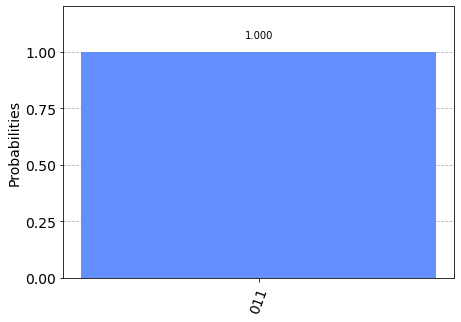

In [6]:
# Compiling the circuit
compiled_circuit = transpile(qc, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1024)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(qc)
print("Total count for possible combinations of output are: ", counts)

# Plot a histogram
plot_histogram(counts)

### **Circuit for estimating inner product of two states $ | \phi \rangle $ and $ | \psi \rangle $**
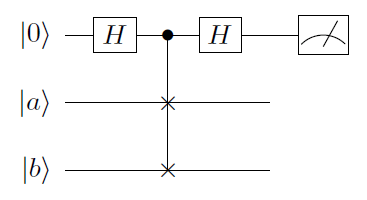


## **2. Procedure for estimating the inner product**

1. Initial state of the system is $ | 0 \psi \phi \rangle $
2. State of the system after Hadamard Gate is $\frac{1}{\sqrt{2}}( | 0 \psi \phi \rangle + | 1 \psi \phi \rangle) $
3. State of the system after CSWAP Gate is $\frac{1}{\sqrt{2}}( | 0 \psi \phi \rangle + | 1 \phi \psi \rangle) $
4. State after applying the second Hadamard gate is $\frac{1}{2}(|0 \phi \psi\rangle + |1 \phi \psi\rangle + |0 \psi \phi\rangle - |1 \psi \phi\rangle) = \frac{1}{2}|0\rangle(|\phi \psi\rangle + |\psi \phi\rangle) + \frac{1}{2}|1\rangle(|\phi \psi\rangle - |\psi \phi\rangle) $
5. The density operator of the system is $\rho = \left[\frac{1}{2}|0\rangle(|\phi \psi\rangle + |\psi \phi\rangle) + \frac{1}{2}|1\rangle(|\phi \psi\rangle - |\psi \phi\rangle)\right]\left[\frac{1}{2}\langle0|(\langle\phi \psi| + \langle\psi \phi|) + \frac{1}{2}\langle1|(\langle\phi \psi| - \langle\psi \phi|)\right] $

6. Let us divide the given state into two systems - 

*   System A - consisting of the ancilla qubit
*   System B - consisting of the two states $ | \psi \rangle $ and $ |\phi \rangle $

7. The reduced  density operator for the system A is $\rho^{A} ≡ tr_{B}(\rho)$ (where, $tr_{B}()$ is the partial trace with respect to system B, and is defined as $tr_{B}(|a_1 \rangle \langle a_2 | \bigotimes |b_1 \rangle \langle b_2 |) \equiv |a_1 \rangle \langle a_2 |tr(|b_1 \rangle \langle b_2|) = |a_1 \rangle \langle a_2 |(\langle b_1 |b_2 \rangle$))

$\implies \ \rho^{A} = \left( \frac{1}{2} + \frac{\langle \psi | \phi \rangle^2}{2}\right) | 0 \rangle \langle 0 | + \left( \frac{1}{2} - \frac{\langle \psi | \phi \rangle^2}{2}\right) | 1 \rangle \langle 1 | $ 

8. Since, for an ensemble $\{p_i,\psi_1\}$ ($p_i$ - probability of the state $\psi_i$), the density operator $\rho$ is $\Sigma_{i = 1}^{n}p_i|\psi_1\rangle \langle \psi_i|$

$\implies |\langle \psi|\phi \rangle| = \sqrt{|P(|0\rangle) - P(|1\rangle)|}
$

where $P(|0\rangle)$ is the probability of getting a $| 0 \rangle$, similarly for $| 1 ⟩$

---
**NOTE:** The extra modulus sign(|.|) in the square root in the expression for $|\langle \psi|\phi \rangle|$ is to guard against experimental error, which can lead to $P(|0\rangle) \le P(|1\rangle)$ 

## **3. Implementing the circuit**

In [13]:
# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(3, 1)

# Adding required gates
circuit.x(1)
circuit.barrier()

circuit.h(0)
circuit.cswap(0,1,2)
circuit.h(0)
circuit.measure(0,0)

# Draw the circuit
circuit.draw()


░ ┌───┐   ┌───┐┌─┐
q_0: ──────░─┤ H ├─■─┤ H ├┤M├
     ┌───┐ ░ └───┘ │ └───┘└╥┘
q_1: ┤ X ├─░───────X───────╫─
     └───┘ ░       │       ║ 
q_2: ──────░───────X───────╫─
           ░               ║ 
c: 1/══════════════════════╩═
                           0

Total count for |0> and |1> are: {'1': 516, '0': 508}


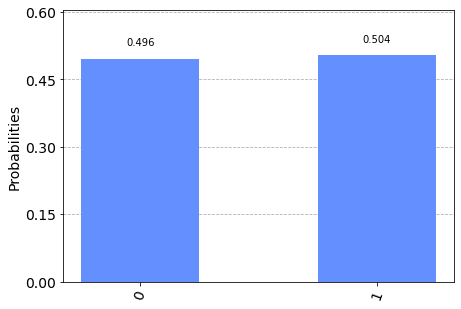

In [28]:
# Compiling the circuit
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1024)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit)
print("Total count for |0> and |1> are:",counts)

# Plot a histogram
plot_histogram(counts)

In [29]:
# Calculating the magnitude of inner product
mag_inner = math.sqrt(abs(counts['0'] - counts['1'])/(counts['0'] + counts['1']))

print("The magnitude of inner product (subject to some error due to running the circuit on a simulator, with finite number of trials) is:", mag_inner)


The magnitude of inner product (subject to some error due to running the circuit on a simulator, with finite number of trials) is: 0.08838834764831845


## **4. Implementing the circuit without an ancilla qubit**

1. Suppose a 2-qubit quantum state is represented in Bell Basis as $a |\beta_{00}\rangle + b |\beta_{01}\rangle +c |\beta_{10}\rangle +d |\beta_{11}\rangle$, passing this 2-qubit quantum state throught the following circuit will convert it into $a |{00}\rangle + b |{01}\rangle +c |{10}\rangle +d |{11}\rangle$.

In [26]:
# Create a Quantum Circuit acting on the q register
circuit2 = QuantumCircuit(2, 2)

# Adding required gates
circuit2.cnot(0,1)
circuit2.h(0)
circuit2.barrier()
circuit2.measure([0,1],[0,1])

# Draw the circuit
circuit2.draw()


┌───┐ ░ ┌─┐   
q_0: ──■──┤ H ├─░─┤M├───
     ┌─┴─┐└───┘ ░ └╥┘┌─┐
q_1: ┤ X ├──────░──╫─┤M├
     └───┘      ░  ║ └╥┘
c: 2/══════════════╩══╩═
                   0  1

Total count for possible states are: {'00': 501, '01': 523}


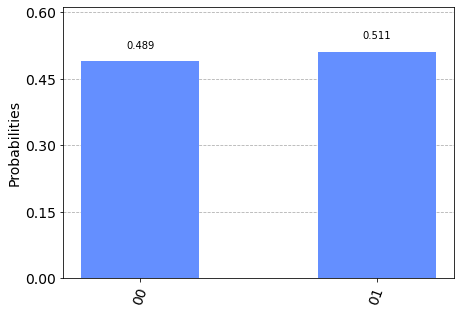

In [35]:
# Compiling the circuit
compiled_circuit = transpile(circuit2, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1024)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit2)
print("Total count for possible states are:",counts)

# Plot a histogram
plot_histogram(counts)

**NOTE:** The above experiment tells us that $a \approx \frac{1}{\sqrt{2}}$ and $c \approx \frac{1}{\sqrt{2}}$ and b = d = 0.

$\implies$ that the initial state ($a |\beta_{00}\rangle + b |\beta_{01}\rangle +c |\beta_{10}\rangle +d |\beta_{11}\rangle$) is $ \frac{1}{\sqrt{2}}|\beta_{00}\rangle + 0 |\beta_{01}\rangle +\frac{1}{\sqrt{2}} |\beta_{10}\rangle +0 |\beta_{11}\rangle$ = $|00\rangle$, which is the initial input, we gave the circuit.

This verifies the above claim.

2. Let the 2 qubits $|\psi\rangle$ and $|\phi\rangle$ be $ (\alpha |0\rangle + \beta |1\rangle)$ and $ (\gamma |0\rangle + \delta |1\rangle)$ respectively
3. The 2 qubit quantum state is $|\psi \phi\rangle = \alpha\gamma |00\rangle + \alpha\delta |01\rangle+ \beta\gamma |10\rangle+ \beta\delta |11\rangle $
4. Expressing the same in Bell basis: 

$\left( \frac{\alpha\gamma + \beta\delta}{\sqrt{2}}\right) |\beta_{00}\rangle$ + ....(ignoring the rest, because we only need the value of $\alpha\gamma + \beta\delta$)

**Final Strategy:**

We want the coeffecient of $|\beta_{00}\rangle$

1. Pass the 2 qubits state into the above mentioned circuit.
2. The coeffecient of $|\beta_{00}\rangle$ will appear as coeffecient of $|00\rangle$
3. Calculate the coeffecient of $|00\rangle$, by experiment.
4. By point 4 of the discussion before this, ($\alpha\gamma + \beta\delta$) =  $\sqrt{2}$ X coeffecient of $|\beta_{00}\rangle$ 

and...the value of ($|\alpha\gamma + \beta\delta|$) = magnitude of required inner product ($|\langle \psi|\phi \rangle|$) 

### **Implementing the circuit**

In [36]:
# Create a Quantum Circuit acting on the q register
circuit3 = QuantumCircuit(2, 2)

# Adding required gates
circuit3.x(0)
circuit3.barrier()
# Initial states of the |psi> and |phi> are |1> and |0> respectively

circuit3.cnot(0,1)
circuit3.h(0)
circuit3.barrier()
circuit3.measure([0,1],[0,1])

# Draw the circuit
circuit3.draw()

┌───┐ ░      ┌───┐ ░ ┌─┐   
q_0: ┤ X ├─░───■──┤ H ├─░─┤M├───
     └───┘ ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
q_1: ──────░─┤ X ├──────░──╫─┤M├
           ░ └───┘      ░  ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1

Total count for possible states are: {'10': 487, '11': 537}


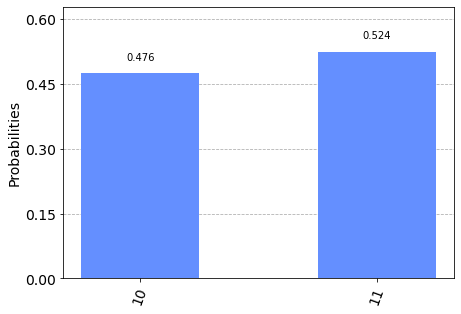

In [37]:
# Compiling the circuit
compiled_circuit = transpile(circuit3, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1024)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(circuit3)
print("Total count for possible states are:",counts)

# Plot a histogram
plot_histogram(counts)

In [42]:
states = ['00','01','10','11']

for i in states:
  if not(i in counts):
    counts.update({i:0})

# Calculate the magnitude of inner product by the above mentioned formula
# coeffecient = sqrt(probability of that state occuring)

mag_inner_2 = math.sqrt(2)*math.sqrt(counts['00']/(counts['00'] + counts['01'] + counts['10'] + counts['11']))

print("Magnitude of the inner product is:", mag_inner_2)

Magnitude of the inner product is: 0.0


Which is the expected output, since the inner product of $|0\rangle$ and $|1\rangle$ is 0.0